# How to use CNN with time series data

The regular measurements of time series result in a similar grid-like data structure as for the image data we have focused on so far. As a result, we can use CNN architectures for univariate and multivariate time series. In the latter case, we consider different time series as channels, similar to the different color signals.

## Imports & Settings

In [1]:
%matplotlib inline

import sys
from time import time
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
tf.autograph.set_verbosity(0, True)
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import (Dense, Flatten, Conv1D, MaxPooling1D, 
                                     Dropout, BatchNormalization)

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [2]:
sys.path.insert(1, Path(sys.path[0], '..').as_posix())
from utils import MultipleTimeSeriesCV, format_time

In [3]:
sns.set_style('whitegrid')

## Prepare Data

In [4]:
prices = (pd.read_hdf('../data/assets.h5', 'quandl/wiki/prices')
          .adj_close
          .unstack().loc['2000':])
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 114.9 MB


### Compute monthly returns

In [5]:
returns = (prices
           .resample('M')
           .last()
           .pct_change()
           .dropna(how='all')
           .loc['2000': '2017']
           .dropna(axis=1)
           .sort_index(ascending=False))

# remove outliers likely representing data errors
returns = returns.where(returns<1).dropna(axis=1)
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215 entries, 2017-12-31 to 2000-02-29
Freq: -1M
Columns: 1511 entries, A to ZQK
dtypes: float64(1511)
memory usage: 2.5 MB


### Create model data

In [6]:
n = len(returns)
nlags = 12
lags = list(range(1, nlags + 1))

In [7]:
cnn_data = []
for i in range(n-nlags-1):
    df = returns.iloc[i:i+nlags+1]        # select outcome and lags
    date = df.index.max()                 # use outcome date
    cnn_data.append(df.reset_index(drop=True)  # append transposed series
                    .transpose()
                    .assign(date=date)
                    .set_index('date', append=True)
                    .sort_index(1, ascending=True))

cnn_data = (pd.concat(cnn_data)
            .rename(columns={0: 'label'})
            .sort_index())

cnn_data.info(null_counts=True)


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 305222 entries, ('A', Timestamp('2001-03-31 00:00:00')) to ('ZQK', Timestamp('2017-12-31 00:00:00'))
Data columns (total 13 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   label   305222 non-null  float64
 1   1       305222 non-null  float64
 2   2       305222 non-null  float64
 3   3       305222 non-null  float64
 4   4       305222 non-null  float64
 5   5       305222 non-null  float64
 6   6       305222 non-null  float64
 7   7       305222 non-null  float64
 8   8       305222 non-null  float64
 9   9       305222 non-null  float64
 10  10      305222 non-null  float64
 11  11      305222 non-null  float64
 12  12      305222 non-null  float64
dtypes: float64(13)
memory usage: 31.5+ MB


## Evaluate features

### Mutual Information

In [8]:
mi = mutual_info_regression(X=cnn_data.drop('label', axis=1), y=cnn_data.label)
mi = pd.Series(mi, index=cnn_data.drop('label', axis=1).columns)

### Information Coefficient

In [28]:
ic = {}
for lag in lags:
    ic[lag] = spearmanr(cnn_data.label, cnn_data[lag])
ic = pd.DataFrame(ic, index=['IC', 'p-value']).T

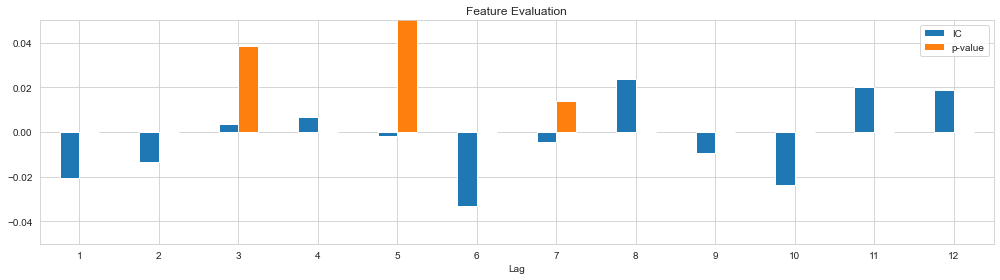

In [33]:
ax = ic.plot.bar(rot=0, figsize=(14,4), ylim=(-0.05, .05), title='Feature Evaluation')
ax.set_xlabel('Lag')
plt.tight_layout()
plt.savefig('figures/cnn_ts1d_feature_ic', dpi=300);

### Plot Metrics

In [11]:
metrics = pd.concat([mi.to_frame('Mutual Information'),
                     ic.IC.to_frame('Information Coefficient')], axis=1)

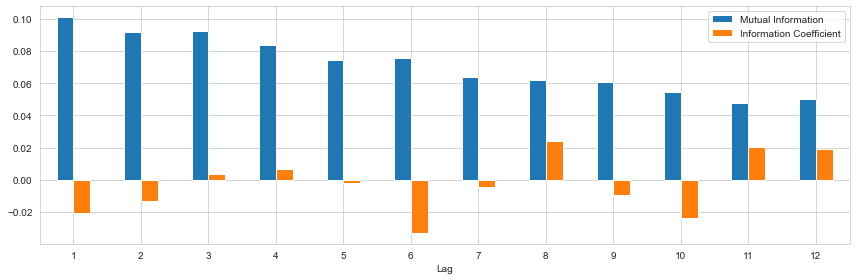

In [12]:
ax = metrics.plot.bar(figsize=(12, 4), rot=0)
ax.set_xlabel('Lag')
plt.tight_layout()
plt.savefig('figures/ts1d_metrics', dpi=300)

## CNN

### Model Architecture

We design a simple one-layer CNN that uses one-dimensional convolutions combined with max pooling to learn time series patterns:

In [8]:
def get_model(filters=32, kernel_size=5, pool_size=2):
    model = Sequential([Conv1D(filters=filters,
                               kernel_size=kernel_size,
                               activation='relu',
                               padding='causal',
                               input_shape=input_shape,
                               use_bias=True,
                               kernel_regularizer=regularizers.l1_l2(l1=1e-5,
                                                                     l2=1e-5)),
                        MaxPooling1D(pool_size=pool_size),
                        Flatten(),
                        BatchNormalization(),
                        Dense(1, activation='linear')])
    model.compile(loss='mse',
                  optimizer='Adam')
    return model

The model has 673 trainable parameters:

We train on returns for the years 2010-16 for 25 epochs (with early stopping) using the default batch size of 32. Each epoch takes around 3s on a single NVIDIA GTX 1080 GPU.

### Callbacks

In [12]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

### Set up CV

In [13]:
cv = MultipleTimeSeriesCV(n_splits=12 * 3,
                          train_period_length=12 * 5,
                          test_period_length=1,
                          lookahead=1)

In [14]:
input_shape = nlags, 1

### Train Model

In [15]:
def get_train_valid_data(X, y, train_idx, test_idx):
    x_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
    x_val, y_val = X.iloc[test_idx, :], y.iloc[test_idx]
    m = X.shape[1]
    return (x_train.values.reshape(-1, m, 1), y_train,
            x_val.values.reshape(-1, m, 1), y_val)

In [16]:
batch_size = 64
epochs = 100

In [17]:
filters = 32
kernel_size = 4
pool_size = 4

In [18]:
get_model(filters=filters,
          kernel_size=kernel_size, 
          pool_size=pool_size).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 12, 32)            160       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 32)             0         
_________________________________________________________________
flatten (Flatten)            (None, 96)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96)                384       
_________________________________________________________________
dense (Dense)                (None, 1)                 97        
Total params: 641
Trainable params: 449
Non-trainable params: 192
_________________________________________________________________


In [19]:
result = {}
start = time()
for fold, (train_idx, test_idx) in enumerate(cv.split(cnn_data)):
    X_train, y_train, X_val, y_val = get_train_valid_data(cnn_data
                                                          .drop('label', axis=1)
                                                          .sort_index(ascending=False),
                                                          cnn_data.label,
                                                          train_idx,
                                                          test_idx)
    test_date = y_val.index.get_level_values('date').max()
    model = get_model(filters=filters,
                      kernel_size=kernel_size,
                      pool_size=pool_size)
    
    best_ic = -np.inf
    stop = 0
    for epoch in range(50):         
        training = model.fit(X_train, y_train,
                             batch_size=batch_size,
                             validation_data=(X_val, y_val),
                             epochs=epoch + 1,
                             initial_epoch=epoch,
#                              callbacks=[early_stopping],
                             verbose=0,
                             shuffle=True)
        predicted = model.predict(X_val).squeeze()
        ic, p_val_ = spearmanr(predicted, y_val)
        if ic > best_ic:
            best_ic = ic
            p_val = p_val_
            print(f'{epoch:02} | {best_ic*100:7.2f} ({p_val:6.2%})')
            stop = 0
        elif np.isnan(ic):
            stop += 1
        else:
            stop += 1
        if stop == 10:
            break
    
#     nrounds = len(training.history['loss'])
    nrounds = epoch-stop
    result[test_date] = [nrounds, best_ic, p_val]
    df = pd.DataFrame(result, index=['epochs', 'IC', 'p-value']).T
    msg = f'{fold + 1:02d} | {format_time(time()-start)} | {nrounds:3.0f} | '
    print(msg + f'{best_ic*100:5.2} ({p_val:7.2%}) | {df.IC.mean()*100:5.2}')

00 |   -3.96 (12.36%)
01 |   -3.92 (12.73%)
02 |    2.85 (26.80%)
04 |    3.36 (19.14%)
05 |    4.10 (11.10%)
09 |    4.55 ( 7.68%)
01 | 00:01:28 |  19 |   4.6 (  7.68%) |   4.6
00 |   -0.88 (73.26%)
03 |    0.02 (99.51%)
05 |    2.26 (37.93%)
02 | 00:03:09 |  15 |   2.3 ( 37.93%) |   3.4
00 |    1.92 (45.48%)
03 | 00:03:56 |  10 |   1.9 ( 45.48%) |   2.9
00 |   -0.36 (88.79%)
01 |   -0.10 (96.96%)
02 |    4.58 ( 7.51%)
04 | 00:04:52 |  12 |   4.6 (  7.51%) |   3.3
00 |    2.39 (35.41%)
05 | 00:05:41 |  10 |   2.4 ( 35.41%) |   3.1
00 |    1.04 (68.72%)
08 |    1.37 (59.49%)
06 | 00:07:06 |  18 |   1.4 ( 59.49%) |   2.8
00 |    0.93 (71.68%)
01 |    2.97 (24.80%)
07 | 00:08:07 |  11 |   3.0 ( 24.80%) |   2.9
00 |   -0.17 (94.81%)
01 |    3.11 (22.70%)
10 |    3.28 (20.22%)
11 |    4.05 (11.58%)
15 |    4.13 (10.89%)
17 |    5.30 ( 3.94%)
08 | 00:10:21 |  27 |   5.3 (  3.94%) |   3.2
00 |   -0.18 (94.33%)
01 |    0.46 (85.78%)
02 |    2.89 (26.16%)
03 |    4.96 ( 5.39%)
09 | 00:11:48 | 

### Evaluate Results

In [20]:
metrics = pd.DataFrame(result, index=['epochs', 'IC', 'p-value']).T

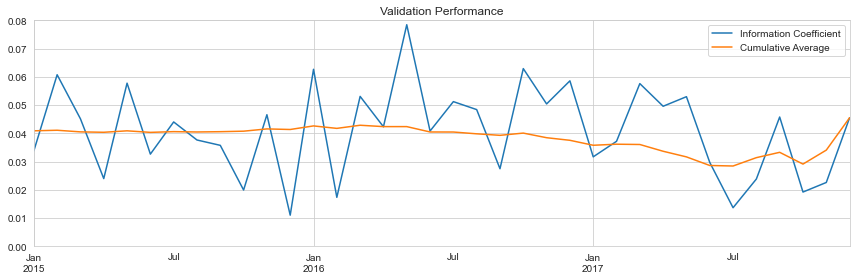

In [27]:
ax = metrics.IC.plot(figsize=(12, 4), 
                     label='Information Coefficient',
                     title='Validation Performance',
                    ylim=(0, .08))
metrics.IC.expanding().mean().plot(ax=ax, label='Cumulative Average')
plt.legend()
plt.tight_layout()
plt.savefig('figures/cnn_ts1d_ic', dpi=300);